In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 23 07:37:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

FICHIER CONFIG

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "drive/MyDrive/Colab Notebooks/cycleGAN/data"
VAL_DIR = "drive/MyDrive/Colab Notebooks/cycleGAN/data"
BATCH_SIZE = 1
LEARNING_RATE = 2e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10.0
NUM_WORKERS = 4
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_A = "drive/MyDrive/Colab Notebooks/cycleGAN/saved_model/genA.pth.tar"
CHECKPOINT_GEN_B = "drive/MyDrive/Colab Notebooks/cycleGAN/saved_model/genB.pth.tar"
CHECKPOINT_CRITIC_A = "drive/MyDrive/Colab Notebooks/cycleGAN/saved_model/criticA.pth.tar"
CHECKPOINT_CRITIC_B = "drive/MyDrive/Colab Notebooks/cycleGAN/saved_model/criticB.pth.tar"

transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

FICHIER DATASET

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset
import nibabel as nib

class customDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.volA = os.listdir(root_A)
        self.volB = os.listdir(root_B)

        #on ne va pas utiliser toutes les images, on va prendre le minimum des 2 datasets
        self.length_dataset = min(len(self.volA), len(self.volB))
        self.volA_len = len(self.volA)
        self.volB_len = len(self.volB)


        self.slicesA = []
        self.slicesB = []

        #extraction des slices de chaque volume dans 2 listes
        for i in range(self.length_dataset):
            volA_path = os.path.join(self.root_A, self.volA[i])
            volB_path = os.path.join(self.root_B, self.volB[i])


            volA = nib.load(volA_path)
            volB = nib.load(volB_path)

            volA = volA.get_fdata()
            volB = volB.get_fdata()
            
            crop = 80

            for j in range(100, 105): #on parcourt les slices du volume
                self.slicesA.append(volA[j,:,:]) #on ajoute la slice à la liste
            
            for j in range(100, 105): #on parcourt les slices du volume
                self.slicesB.append(volB[j,:,:]) #on ajoute la slice à la liste

        
        self.length_dataset = min(len(self.slicesA), len(self.slicesB))

        #on cherche la dimension minimale en x et en y pour pouvoir les mettre à la même taille
        self.min_x = 100000
        self.min_y = 100000
        for i in range(self.length_dataset):
            if self.slicesA[i].shape[0] < self.min_x:
                self.min_x = self.slicesA[i].shape[0]
            if self.slicesA[i].shape[1] < self.min_y:
                self.min_y = self.slicesA[i].shape[1]
            
            if self.slicesB[i].shape[0] < self.min_x:
                self.min_x = self.slicesB[i].shape[0]
            if self.slicesB[i].shape[1] < self.min_y:
                self.min_y = self.slicesB[i].shape[1]
            
        #on met à la même taille les slices
        for i in range(self.length_dataset):
            self.slicesA[i] = self.slicesA[i][0:self.min_x, 0:self.min_y]
            self.slicesB[i] = self.slicesB[i][0:self.min_x, 0:self.min_y]

        #on normalise les slices
        for i in range(self.length_dataset):
            self.slicesA[i] = self.slicesA[i] / np.max(self.slicesA[i])
            self.slicesB[i] = self.slicesB[i] / np.max(self.slicesB[i])
        

        #on transforme les slices en float
        for i in range(self.length_dataset):
            self.slicesA[i] = self.slicesA[i].astype(np.float32)
            self.slicesB[i] = self.slicesB[i].astype(np.float32)

        
        


    def __len__(self):
        return self.length_dataset 

    def __getitem__(self, index):
        return self.slicesA[index], self.slicesB[index] #on renvoie les slices de chaque volume
        

FICHIER DISCRIMINATOR MODEL

In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


FICHER GENERATOR

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode = "reflect", **kwargs) if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True) if use_act 
            else nn.Identity()
        )
    
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1),
            ConvBlock(channels, channels, use_act = False, kernel_size = 3, stride = 1, padding = 1)
        )
    
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride = 1, padding = 3, padding_mode = "reflect"),
            nn.ReLU(inplace = True),
        )

        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size = 3, stride = 2, padding = 1),
                ConvBlock(num_features*2, num_features*4, kernel_size = 3, stride = 2, padding = 1)
            ]
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                ConvBlock(num_features*2, num_features*1, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride = 1, padding = 3, padding_mode = "reflect")
    
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))
    


FICHIER ISCUDAAVAILABLE

In [ ]:
import torch

print(torch.cuda.is_available())

True


FICHIER UTILS

In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

FICHIER TRAIN

  0%|          | 0/240 [00:00<?, ?it/s]

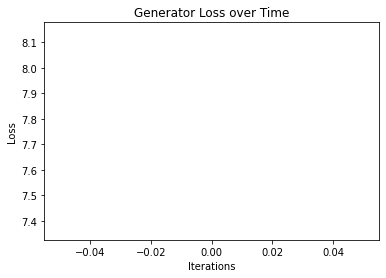

 21%|██        | 50/240 [00:09<00:34,  5.56it/s]

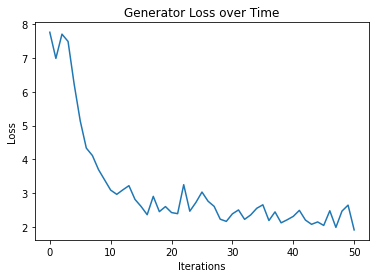

 42%|████▏     | 100/240 [00:18<00:25,  5.49it/s]

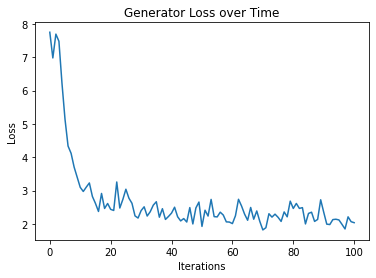

 62%|██████▎   | 150/240 [00:28<00:16,  5.53it/s]

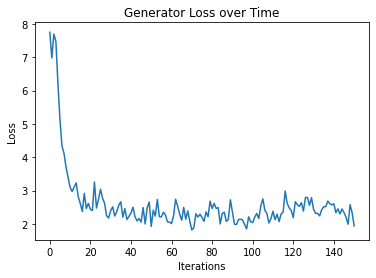

 83%|████████▎ | 200/240 [00:37<00:07,  5.53it/s]

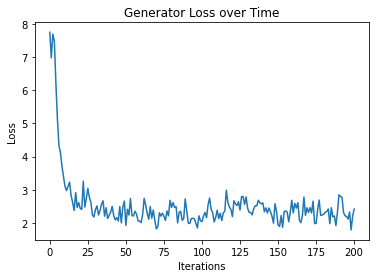

100%|██████████| 240/240 [00:44<00:00,  5.36it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

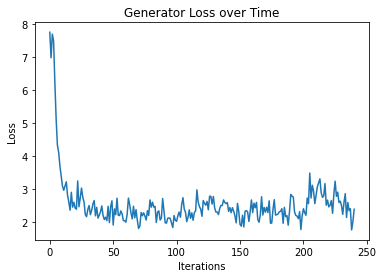

 21%|██        | 50/240 [00:09<00:34,  5.47it/s]

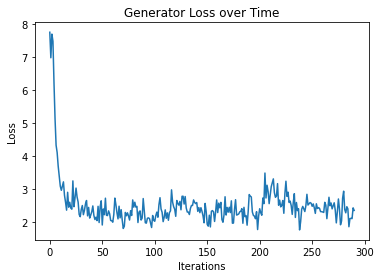

 42%|████▏     | 100/240 [00:19<00:25,  5.48it/s]

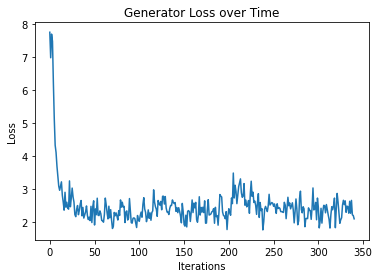

 62%|██████▎   | 150/240 [00:28<00:16,  5.53it/s]

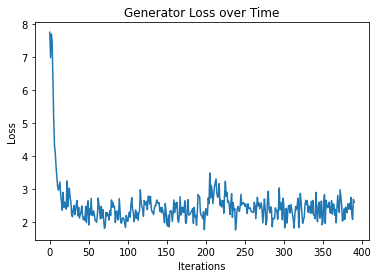

 83%|████████▎ | 200/240 [00:37<00:07,  5.47it/s]

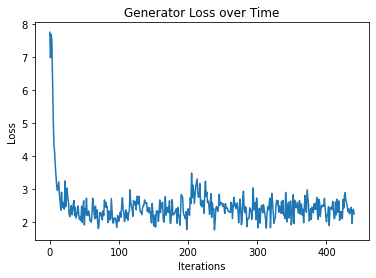

100%|██████████| 240/240 [00:45<00:00,  5.31it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

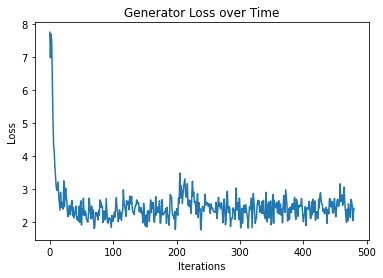

 21%|██        | 50/240 [00:09<00:37,  5.03it/s]

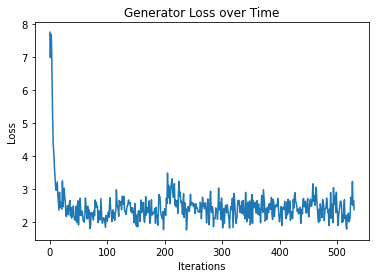

 42%|████▏     | 100/240 [00:19<00:25,  5.56it/s]

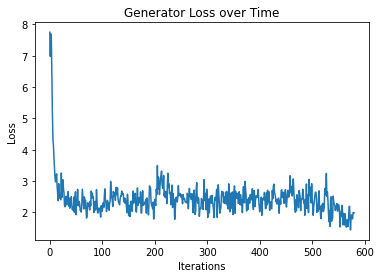

 62%|██████▎   | 150/240 [00:28<00:16,  5.55it/s]

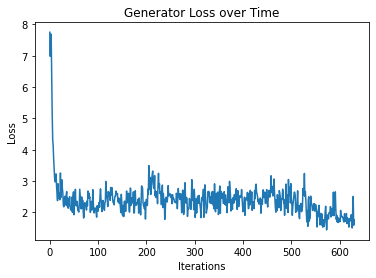

 83%|████████▎ | 200/240 [00:37<00:07,  5.52it/s]

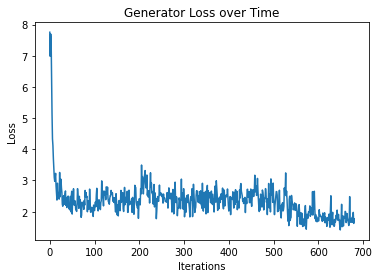

100%|██████████| 240/240 [00:45<00:00,  5.30it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

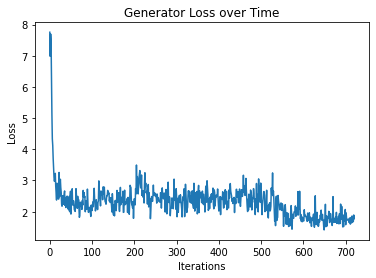

 21%|██        | 50/240 [00:09<00:35,  5.29it/s]

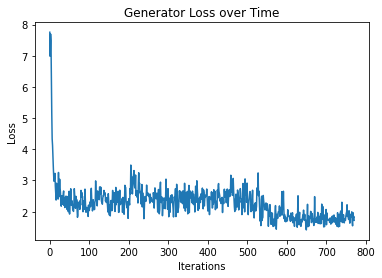

 42%|████▏     | 100/240 [00:19<00:25,  5.47it/s]

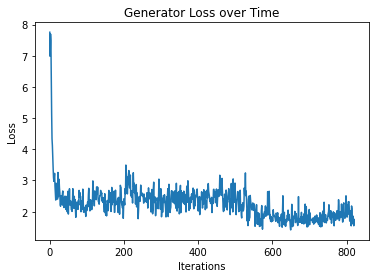

 62%|██████▎   | 150/240 [00:28<00:16,  5.46it/s]

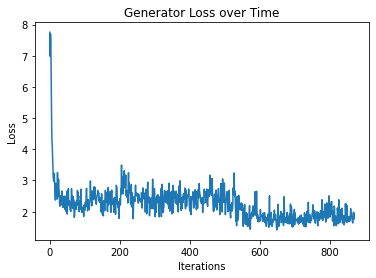

 83%|████████▎ | 200/240 [00:37<00:07,  5.44it/s]

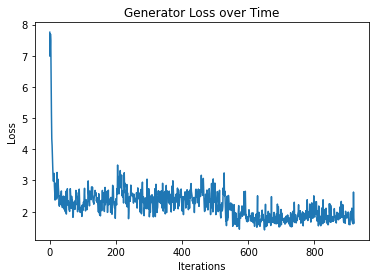

100%|██████████| 240/240 [00:45<00:00,  5.27it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

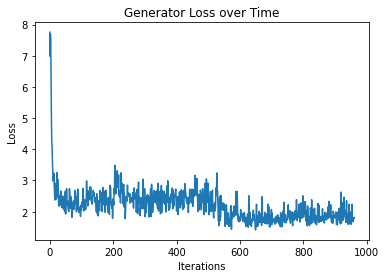

 21%|██        | 50/240 [00:11<00:36,  5.19it/s]

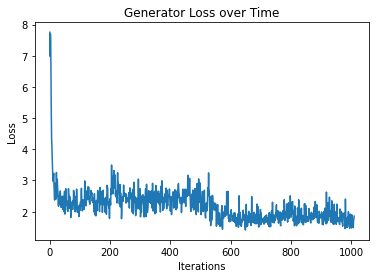

 42%|████▏     | 100/240 [00:20<00:25,  5.47it/s]

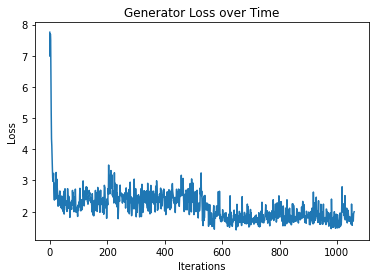

 62%|██████▎   | 150/240 [00:29<00:16,  5.42it/s]

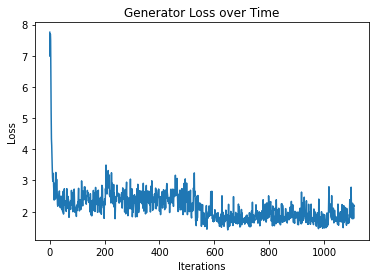

 83%|████████▎ | 200/240 [00:39<00:07,  5.40it/s]

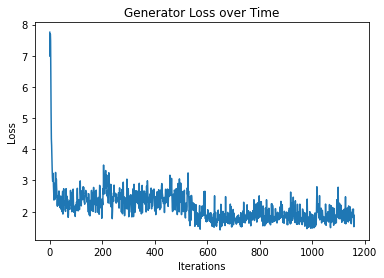

100%|██████████| 240/240 [00:47<00:00,  5.10it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

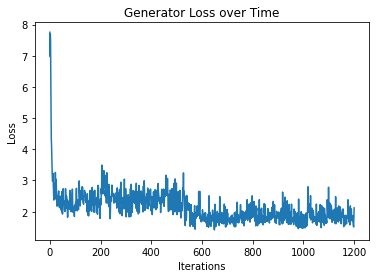

 21%|██        | 50/240 [00:09<00:41,  4.54it/s]

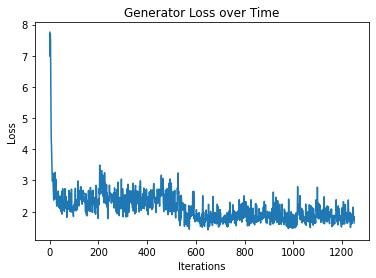

 42%|████▏     | 100/240 [00:19<00:25,  5.43it/s]

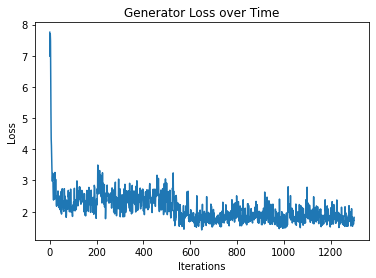

 62%|██████▎   | 150/240 [00:29<00:16,  5.46it/s]

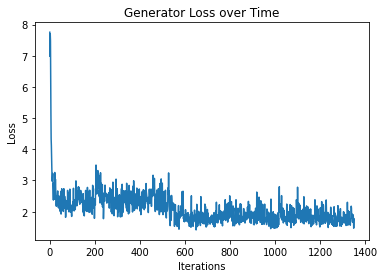

 83%|████████▎ | 200/240 [00:38<00:07,  5.39it/s]

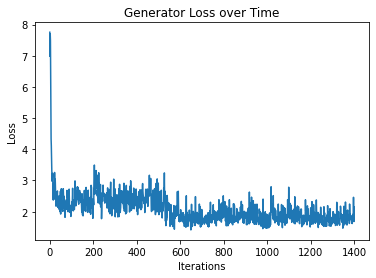

100%|██████████| 240/240 [00:46<00:00,  5.22it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

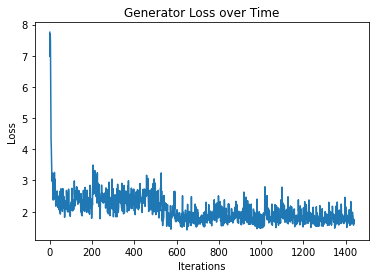

 21%|██        | 50/240 [00:09<00:37,  5.03it/s]

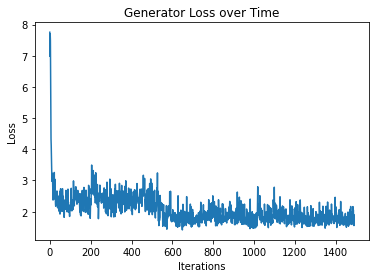

 42%|████▏     | 100/240 [00:19<00:25,  5.41it/s]

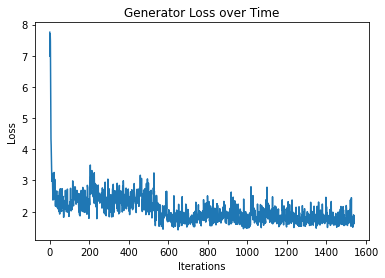

 62%|██████▎   | 150/240 [00:28<00:16,  5.44it/s]

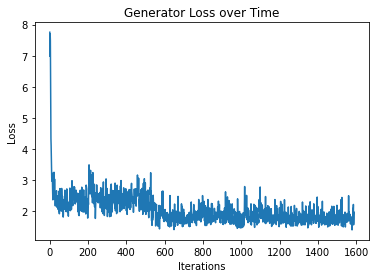

 83%|████████▎ | 200/240 [00:38<00:07,  5.43it/s]

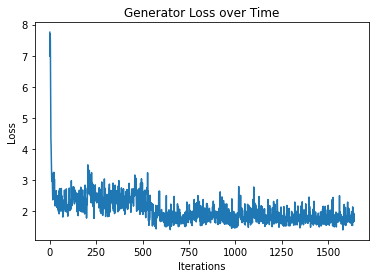

100%|██████████| 240/240 [00:45<00:00,  5.23it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

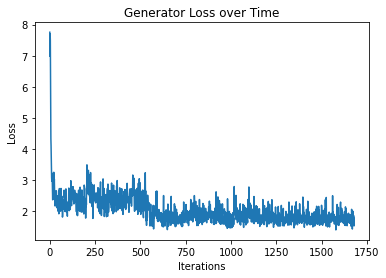

 21%|██        | 50/240 [00:09<00:35,  5.28it/s]

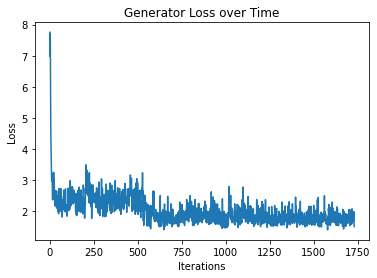

 42%|████▏     | 100/240 [00:19<00:25,  5.48it/s]

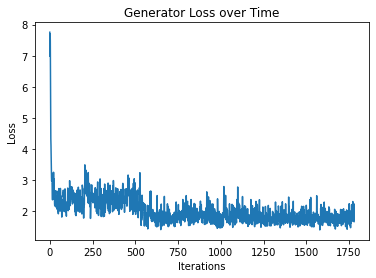

 62%|██████▎   | 150/240 [00:29<00:16,  5.47it/s]

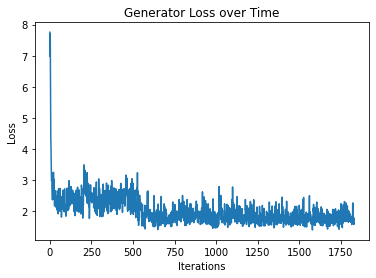

 83%|████████▎ | 200/240 [00:38<00:07,  5.31it/s]

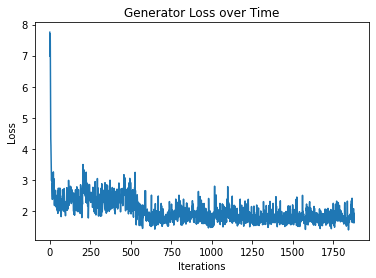

100%|██████████| 240/240 [00:46<00:00,  5.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

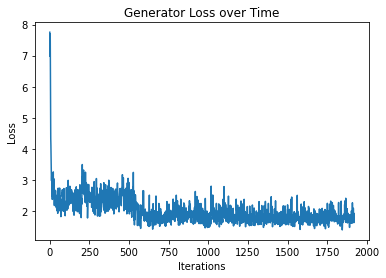

 21%|██        | 50/240 [00:09<00:36,  5.25it/s]

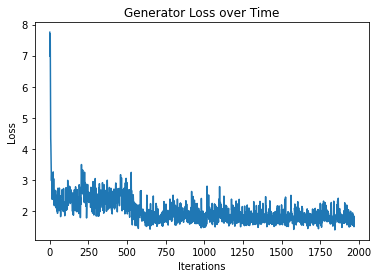

 42%|████▏     | 100/240 [00:19<00:25,  5.44it/s]

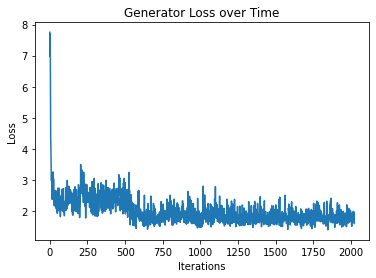

 62%|██████▎   | 150/240 [00:28<00:16,  5.37it/s]

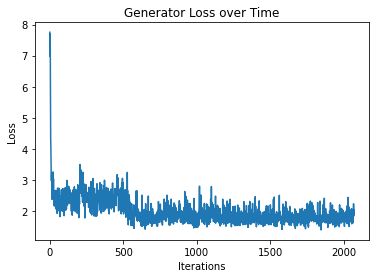

 83%|████████▎ | 200/240 [00:38<00:07,  5.42it/s]

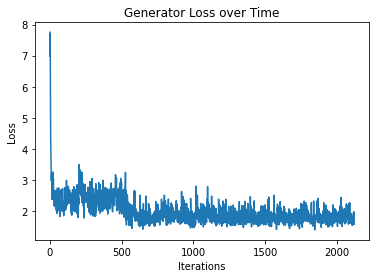

100%|██████████| 240/240 [00:45<00:00,  5.22it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

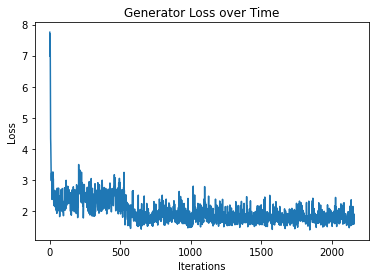

 21%|██        | 50/240 [00:09<00:38,  4.95it/s]

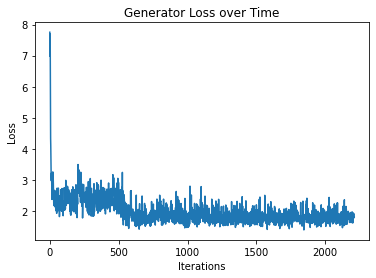

 42%|████▏     | 100/240 [00:19<00:25,  5.50it/s]

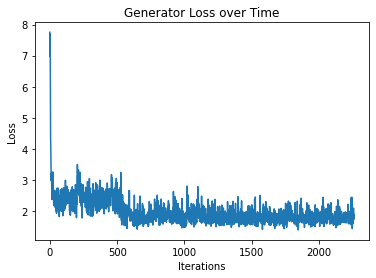

 62%|██████▎   | 150/240 [00:28<00:16,  5.42it/s]

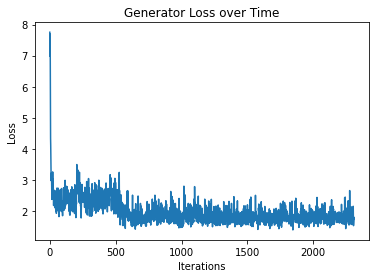

 83%|████████▎ | 200/240 [00:38<00:07,  5.44it/s]

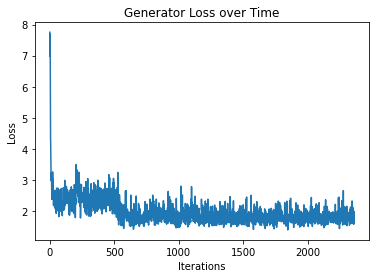

100%|██████████| 240/240 [00:45<00:00,  5.24it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

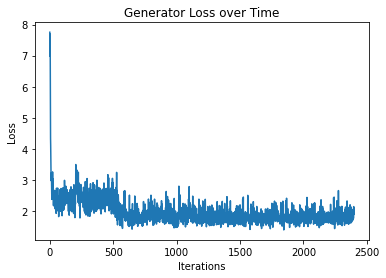

 21%|██        | 50/240 [00:09<00:35,  5.33it/s]

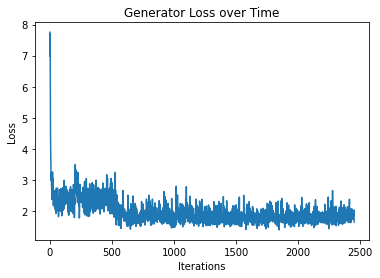

 42%|████▏     | 100/240 [00:19<00:25,  5.55it/s]

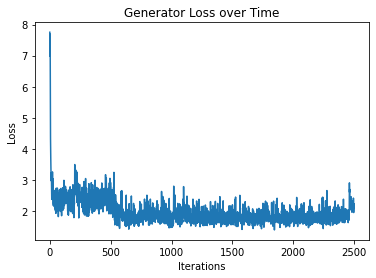

 62%|██████▎   | 150/240 [00:28<00:16,  5.50it/s]

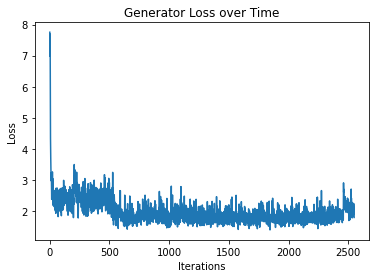

 83%|████████▎ | 200/240 [00:38<00:07,  5.37it/s]

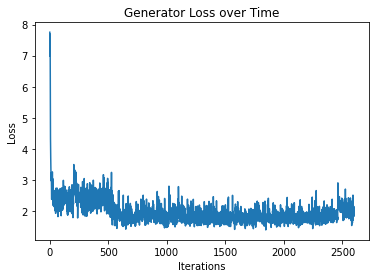

100%|██████████| 240/240 [00:45<00:00,  5.23it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

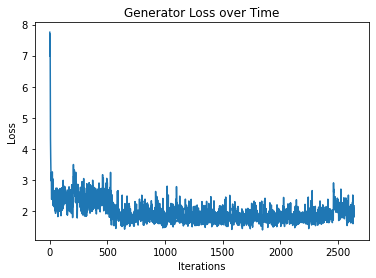

 21%|██        | 50/240 [00:09<00:36,  5.18it/s]

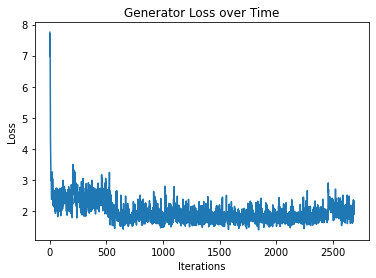

 42%|████▏     | 100/240 [00:19<00:25,  5.46it/s]

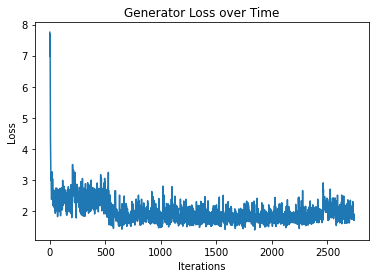

 62%|██████▎   | 150/240 [00:28<00:16,  5.48it/s]

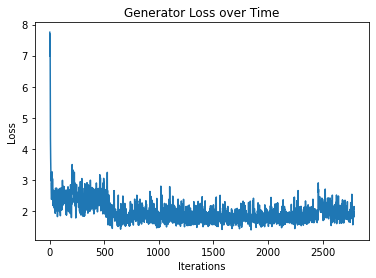

 83%|████████▎ | 200/240 [00:38<00:07,  5.42it/s]

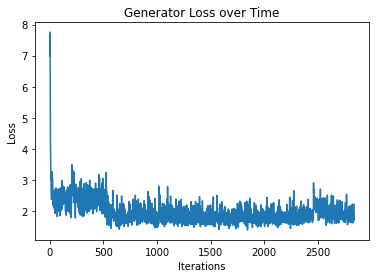

100%|██████████| 240/240 [00:45<00:00,  5.22it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

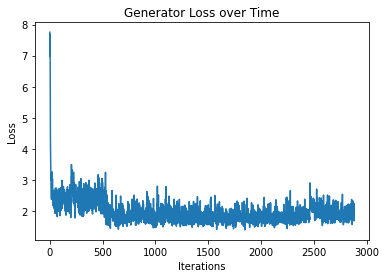

 21%|██        | 50/240 [00:09<00:38,  4.99it/s]

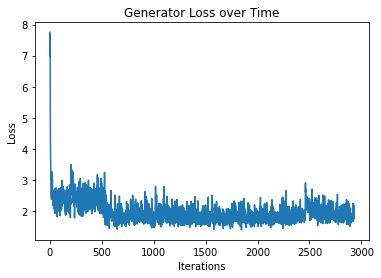

 42%|████▏     | 100/240 [00:19<00:25,  5.51it/s]

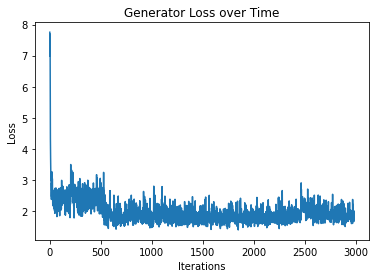

 62%|██████▎   | 150/240 [00:28<00:16,  5.50it/s]

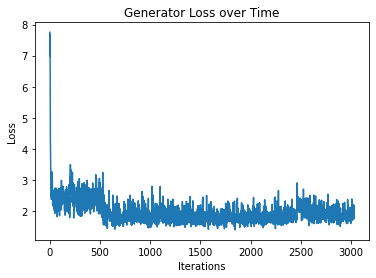

 83%|████████▎ | 200/240 [00:37<00:07,  5.43it/s]

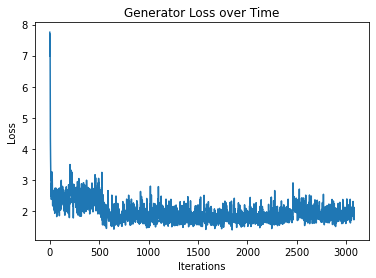

100%|██████████| 240/240 [00:45<00:00,  5.27it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

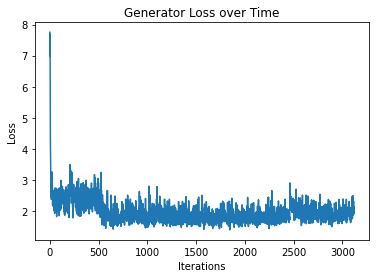

 21%|██        | 50/240 [00:09<00:36,  5.17it/s]

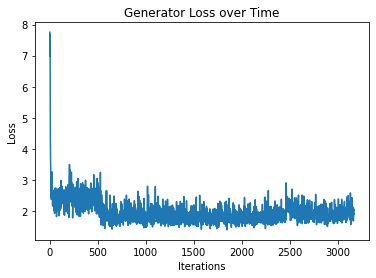

 42%|████▏     | 100/240 [00:19<00:25,  5.49it/s]

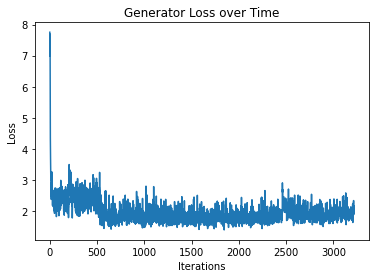

 62%|██████▎   | 150/240 [00:28<00:16,  5.40it/s]

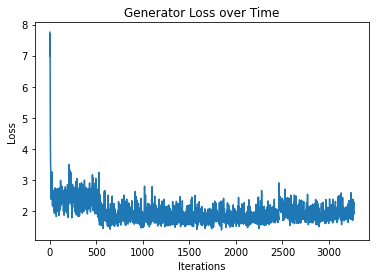

 83%|████████▎ | 200/240 [00:38<00:07,  5.47it/s]

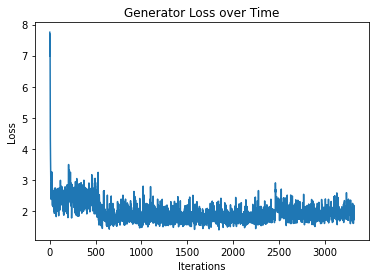

100%|██████████| 240/240 [00:45<00:00,  5.23it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

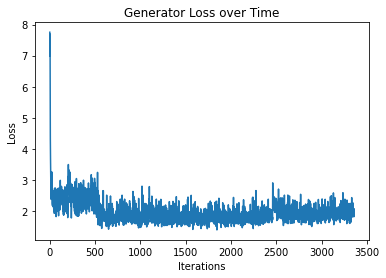

 21%|██        | 50/240 [00:10<00:37,  5.12it/s]

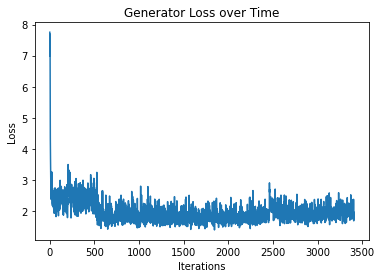

 42%|████▏     | 100/240 [00:20<00:25,  5.51it/s]

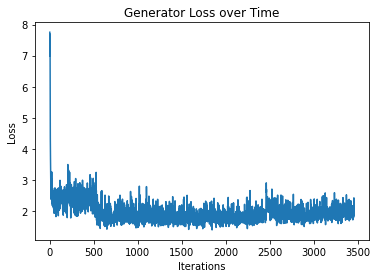

 62%|██████▎   | 150/240 [00:29<00:16,  5.57it/s]

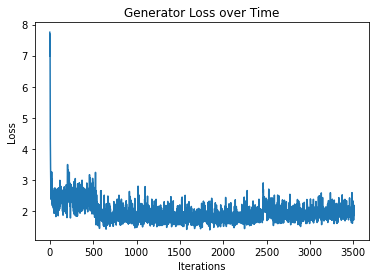

 83%|████████▎ | 200/240 [00:39<00:07,  5.42it/s]

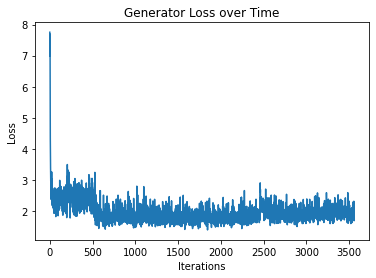

100%|██████████| 240/240 [00:46<00:00,  5.13it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

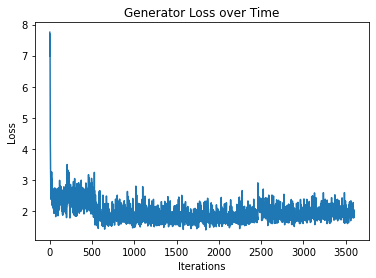

 21%|██        | 50/240 [00:09<00:37,  5.09it/s]

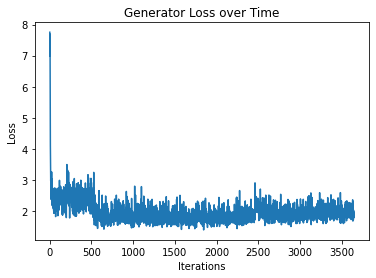

 42%|████▏     | 100/240 [00:19<00:25,  5.46it/s]

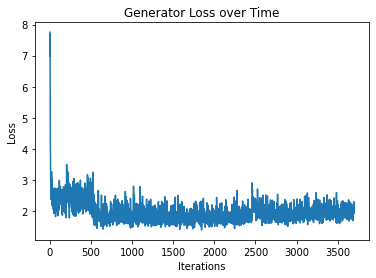

 62%|██████▎   | 150/240 [00:28<00:16,  5.48it/s]

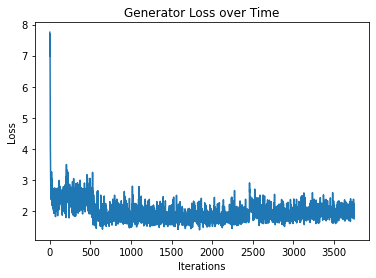

 83%|████████▎ | 200/240 [00:37<00:07,  5.59it/s]

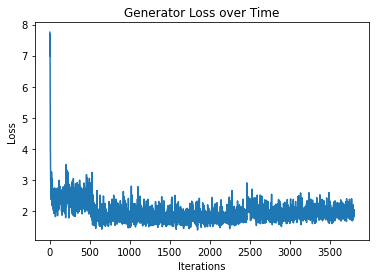

100%|██████████| 240/240 [00:45<00:00,  5.29it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

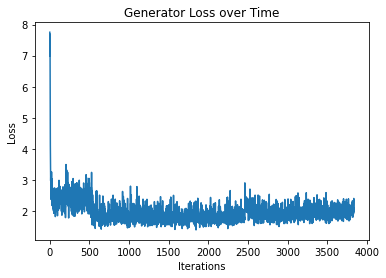

 21%|██        | 50/240 [00:09<00:34,  5.48it/s]

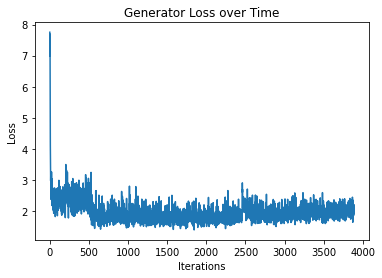

 42%|████▏     | 100/240 [00:19<00:24,  5.62it/s]

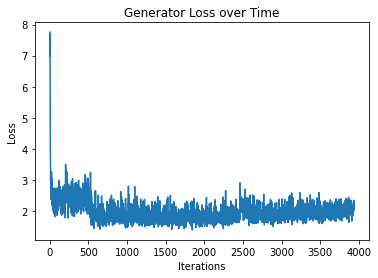

 62%|██████▎   | 150/240 [00:28<00:16,  5.53it/s]

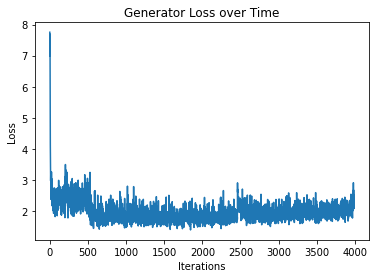

 83%|████████▎ | 200/240 [00:37<00:07,  5.56it/s]

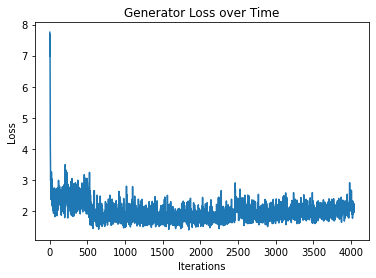

100%|██████████| 240/240 [00:44<00:00,  5.34it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

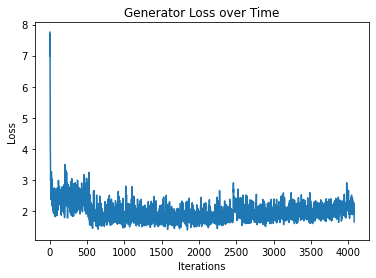

 21%|██        | 50/240 [00:09<00:38,  4.88it/s]

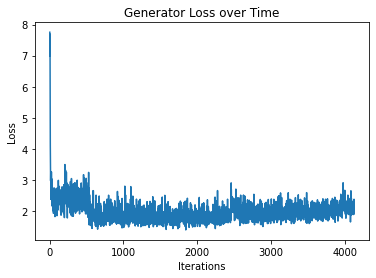

 42%|████▏     | 100/240 [00:19<00:24,  5.60it/s]

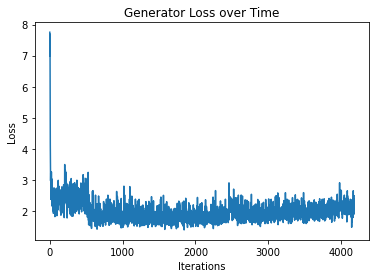

 62%|██████▎   | 150/240 [00:28<00:16,  5.60it/s]

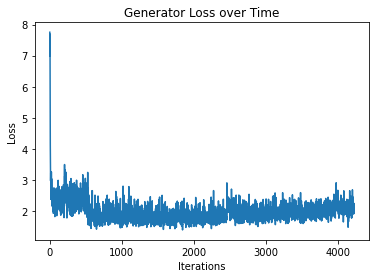

 83%|████████▎ | 200/240 [00:37<00:07,  5.59it/s]

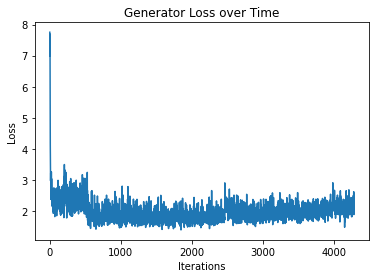

100%|██████████| 240/240 [00:44<00:00,  5.35it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

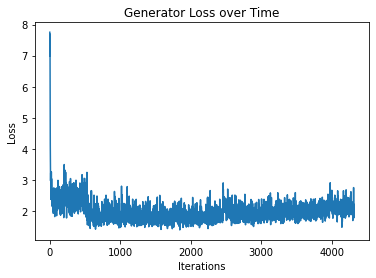

 21%|██        | 50/240 [00:09<00:34,  5.54it/s]

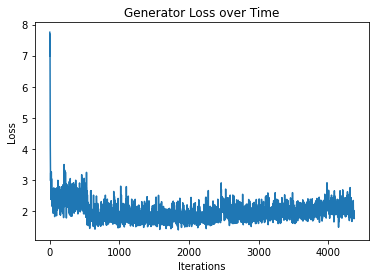

 42%|████▏     | 100/240 [00:19<00:25,  5.53it/s]

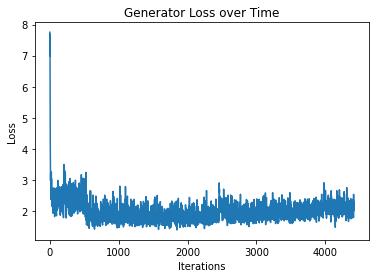

 62%|██████▎   | 150/240 [00:28<00:16,  5.52it/s]

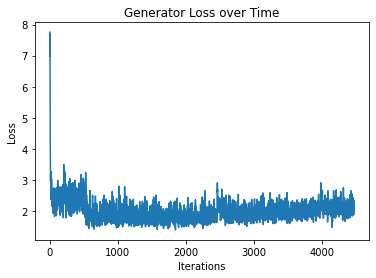

 83%|████████▎ | 200/240 [00:37<00:07,  5.48it/s]

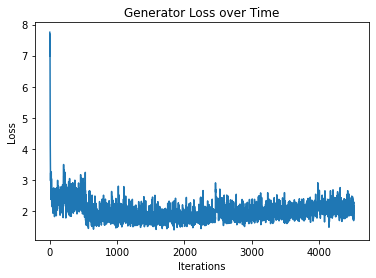

100%|██████████| 240/240 [00:45<00:00,  5.30it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

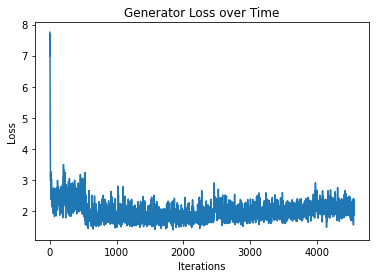

 21%|██        | 50/240 [00:09<00:35,  5.32it/s]

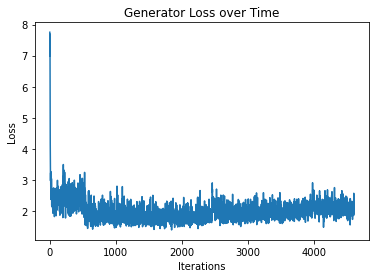

 42%|████▏     | 100/240 [00:19<00:25,  5.57it/s]

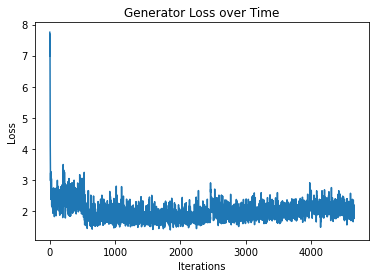

 62%|██████▎   | 150/240 [00:28<00:16,  5.55it/s]

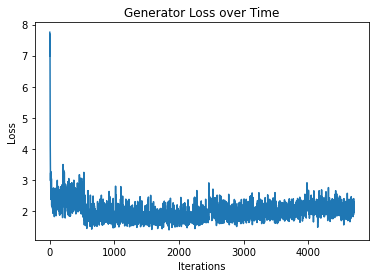

 83%|████████▎ | 200/240 [00:37<00:07,  5.57it/s]

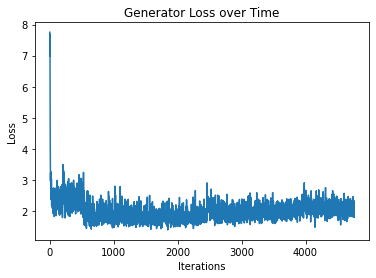

100%|██████████| 240/240 [00:45<00:00,  5.33it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

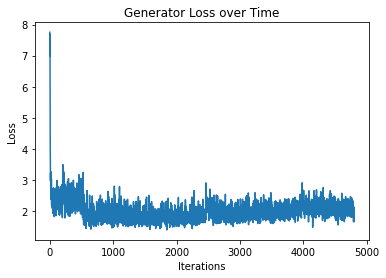

 21%|██        | 50/240 [00:09<00:35,  5.28it/s]

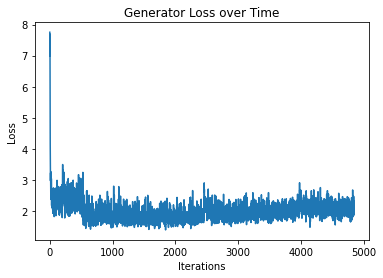

 42%|████▏     | 100/240 [00:19<00:25,  5.50it/s]

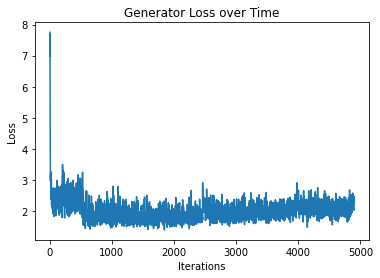

 62%|██████▎   | 150/240 [00:28<00:16,  5.48it/s]

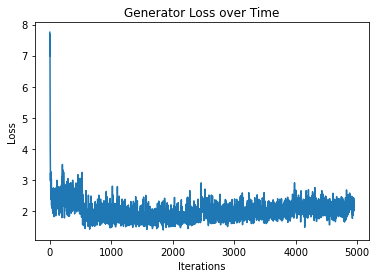

 83%|████████▎ | 200/240 [00:38<00:07,  5.27it/s]

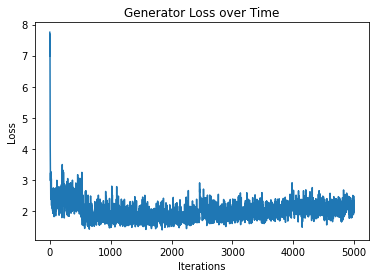

100%|██████████| 240/240 [00:45<00:00,  5.26it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

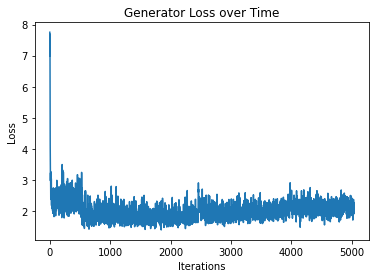

 21%|██        | 50/240 [00:09<00:36,  5.26it/s]

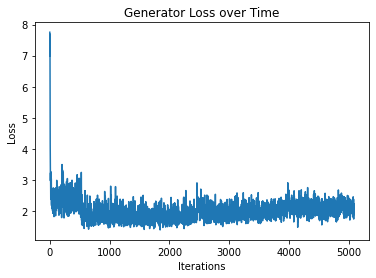

 42%|████▏     | 100/240 [00:19<00:25,  5.51it/s]

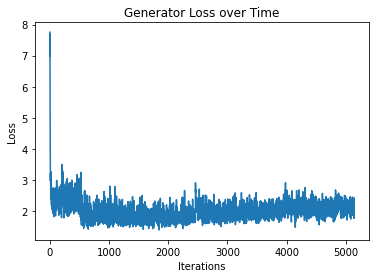

 62%|██████▎   | 150/240 [00:28<00:16,  5.44it/s]

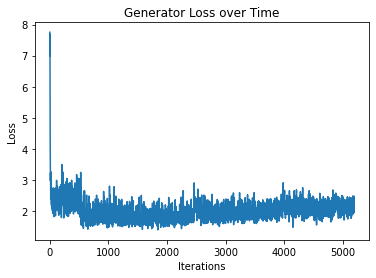

 83%|████████▎ | 200/240 [00:37<00:07,  5.53it/s]

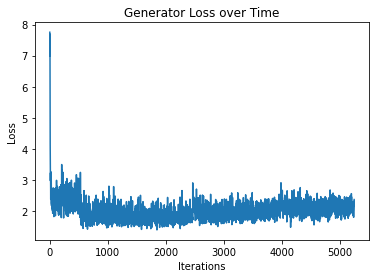

100%|██████████| 240/240 [00:45<00:00,  5.28it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

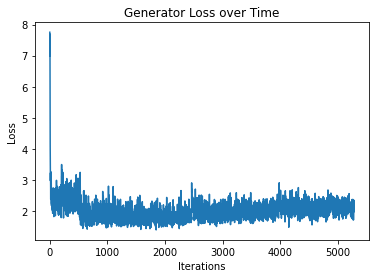

 21%|██        | 50/240 [00:09<00:35,  5.30it/s]

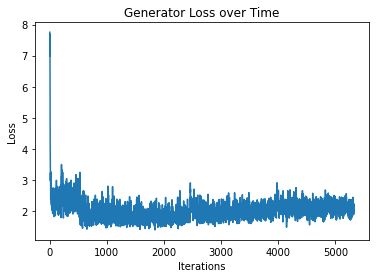

 42%|████▏     | 100/240 [00:19<00:25,  5.41it/s]

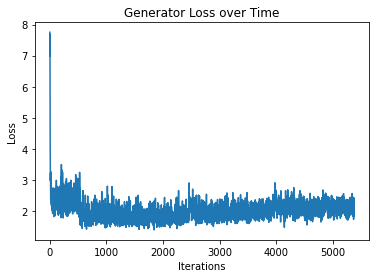

 62%|██████▎   | 150/240 [00:28<00:16,  5.45it/s]

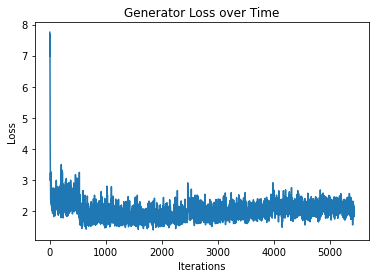

 83%|████████▎ | 200/240 [00:37<00:07,  5.55it/s]

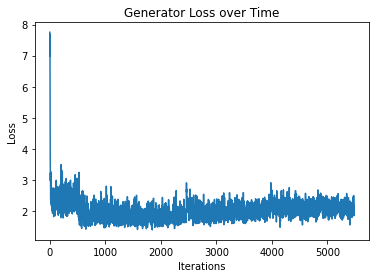

100%|██████████| 240/240 [00:45<00:00,  5.28it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

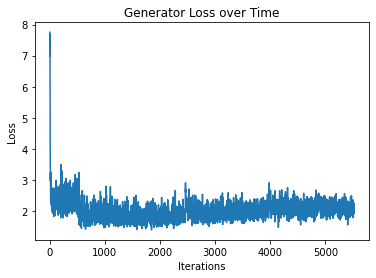

 21%|██        | 50/240 [00:10<00:37,  5.08it/s]

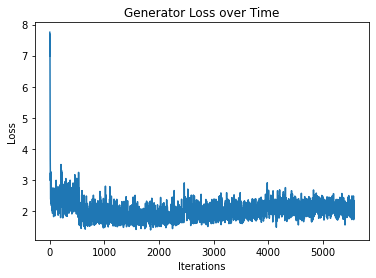

 42%|████▏     | 100/240 [00:20<00:25,  5.45it/s]

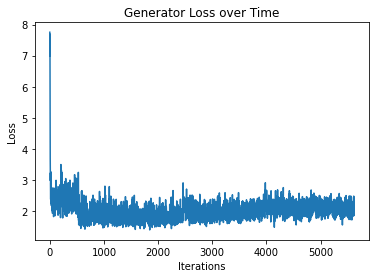

 62%|██████▎   | 150/240 [00:29<00:16,  5.52it/s]

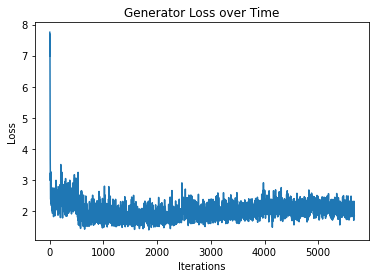

 83%|████████▎ | 200/240 [00:38<00:07,  5.36it/s]

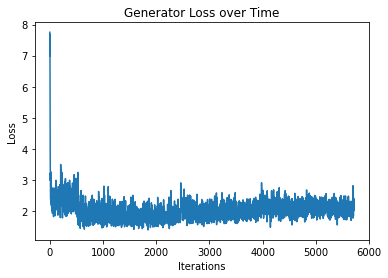

100%|██████████| 240/240 [00:46<00:00,  5.15it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

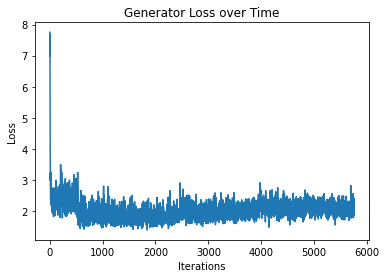

 21%|██        | 50/240 [00:09<00:35,  5.34it/s]

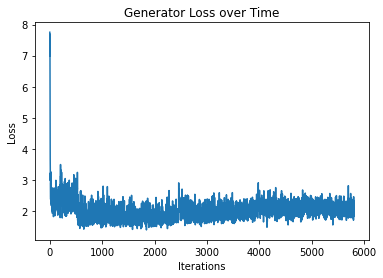

 42%|████▏     | 100/240 [00:19<00:25,  5.48it/s]

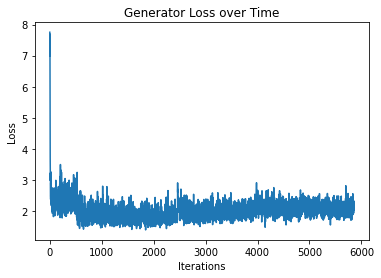

 62%|██████▎   | 150/240 [00:28<00:16,  5.47it/s]

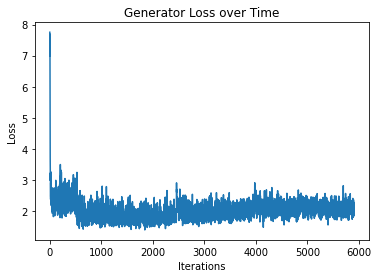

 83%|████████▎ | 200/240 [00:37<00:07,  5.51it/s]

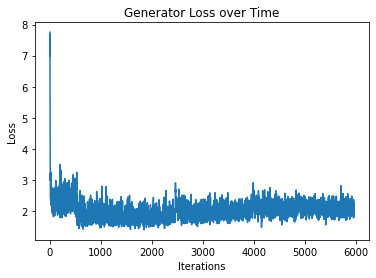

100%|██████████| 240/240 [00:45<00:00,  5.27it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

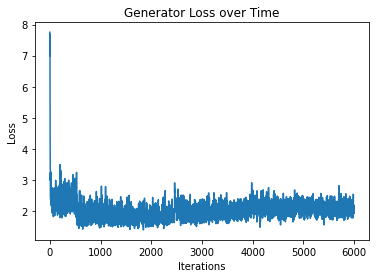

 21%|██        | 50/240 [00:09<00:37,  5.12it/s]

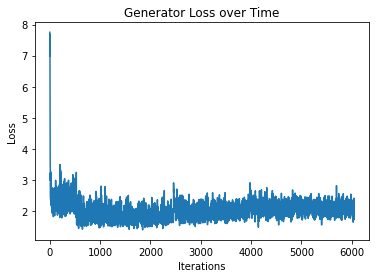

 42%|████▏     | 100/240 [00:19<00:25,  5.47it/s]

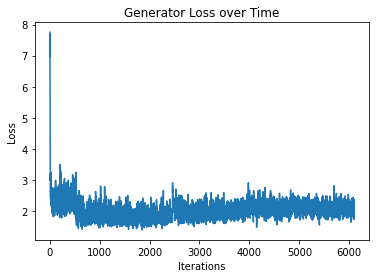

 62%|██████▎   | 150/240 [00:28<00:16,  5.45it/s]

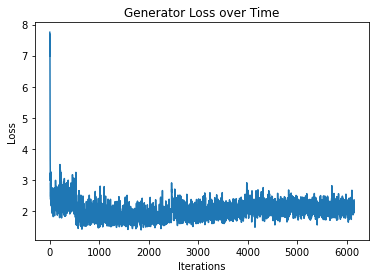

 83%|████████▎ | 200/240 [00:38<00:07,  5.41it/s]

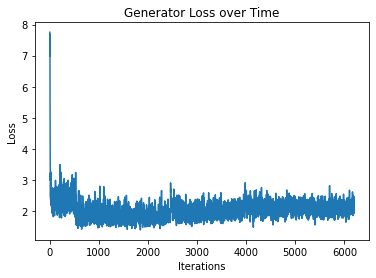

100%|██████████| 240/240 [00:45<00:00,  5.24it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

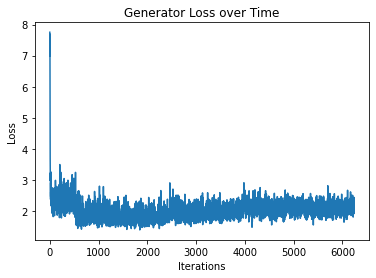

 21%|██        | 50/240 [00:09<00:36,  5.19it/s]

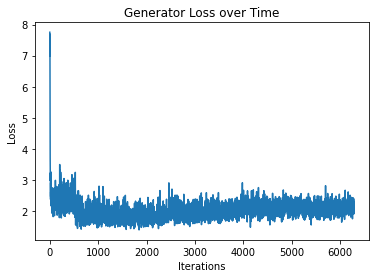

 42%|████▏     | 100/240 [00:19<00:25,  5.54it/s]

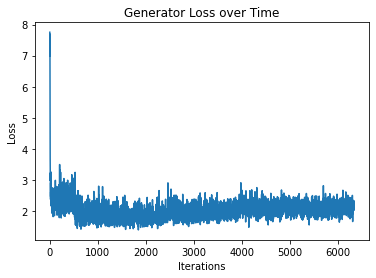

 62%|██████▎   | 150/240 [00:28<00:16,  5.50it/s]

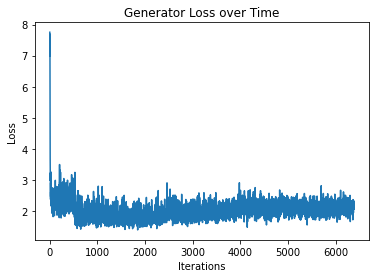

 83%|████████▎ | 200/240 [00:37<00:07,  5.44it/s]

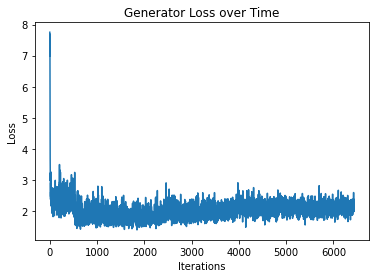

100%|██████████| 240/240 [00:45<00:00,  5.29it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

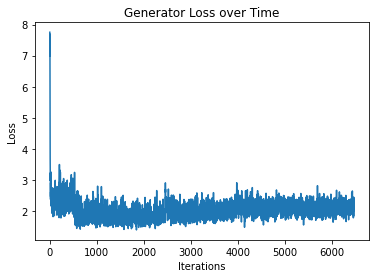

 21%|██        | 50/240 [00:09<00:38,  4.99it/s]

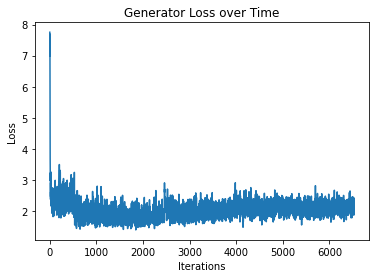

 42%|████▏     | 100/240 [00:19<00:25,  5.45it/s]

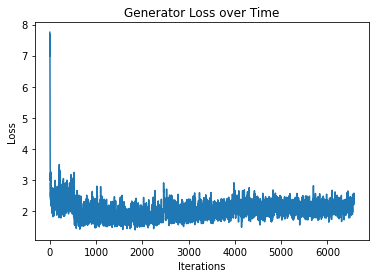

 62%|██████▎   | 150/240 [00:28<00:16,  5.40it/s]

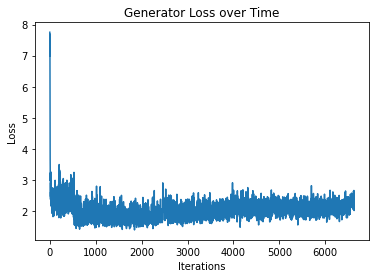

 83%|████████▎ | 200/240 [00:37<00:07,  5.37it/s]

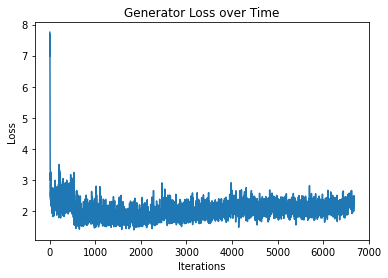

100%|██████████| 240/240 [00:45<00:00,  5.26it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

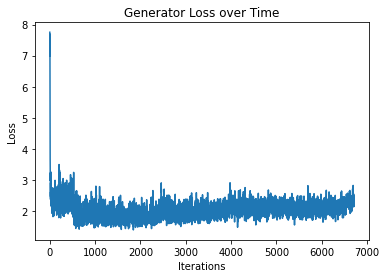

 21%|██        | 50/240 [00:09<00:36,  5.20it/s]

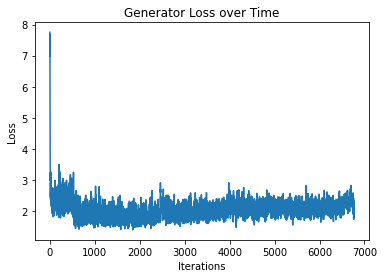

 42%|████▏     | 100/240 [00:19<00:25,  5.48it/s]

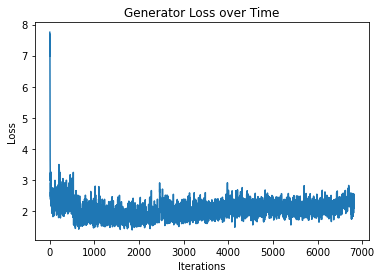

 62%|██████▎   | 150/240 [00:28<00:16,  5.45it/s]

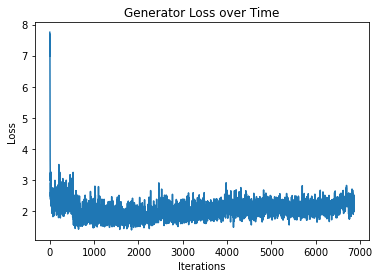

 83%|████████▎ | 200/240 [00:37<00:07,  5.50it/s]

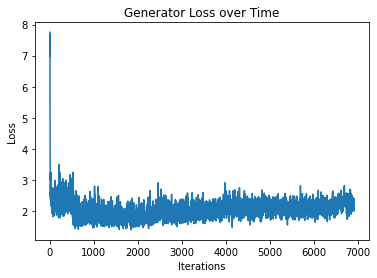

100%|██████████| 240/240 [00:45<00:00,  5.29it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

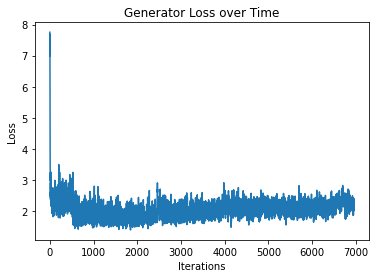

 21%|██        | 50/240 [00:09<00:36,  5.26it/s]

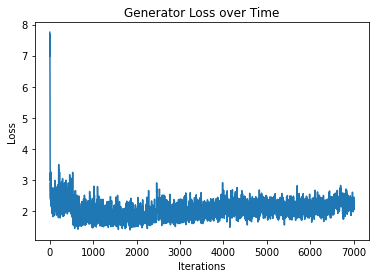

 42%|████▏     | 100/240 [00:19<00:25,  5.44it/s]

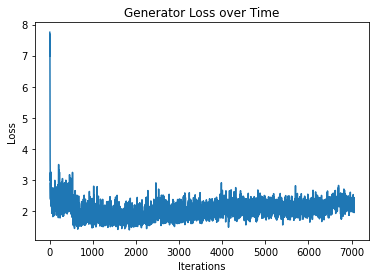

 62%|██████▎   | 150/240 [00:28<00:16,  5.42it/s]

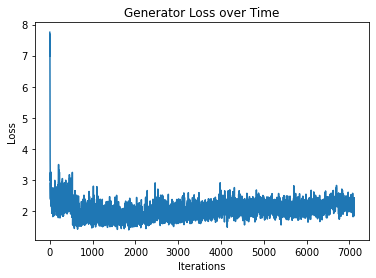

 83%|████████▎ | 200/240 [00:37<00:07,  5.52it/s]

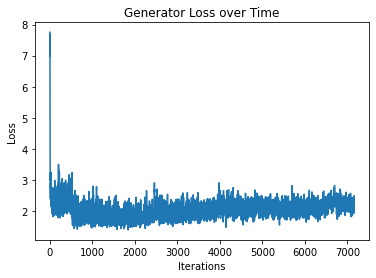

100%|██████████| 240/240 [00:45<00:00,  5.28it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

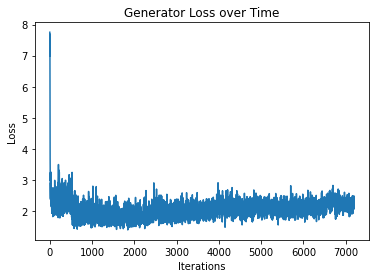

 21%|██        | 50/240 [00:09<00:37,  5.05it/s]

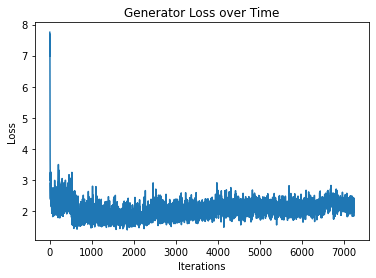

 42%|████▏     | 100/240 [00:19<00:25,  5.48it/s]

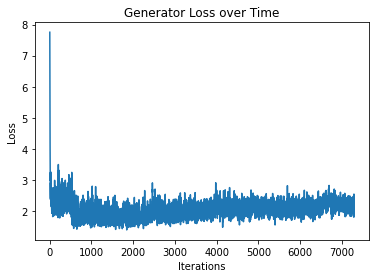

 62%|██████▎   | 150/240 [00:28<00:16,  5.52it/s]

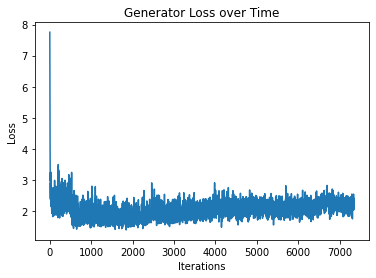

 83%|████████▎ | 200/240 [00:38<00:07,  5.50it/s]

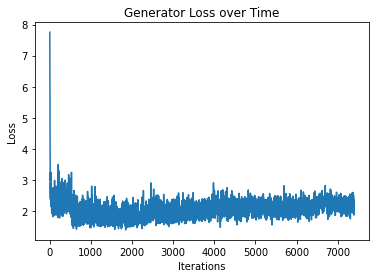

100%|██████████| 240/240 [00:45<00:00,  5.26it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

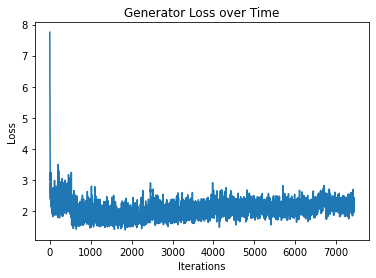

 21%|██        | 50/240 [00:10<00:38,  4.96it/s]

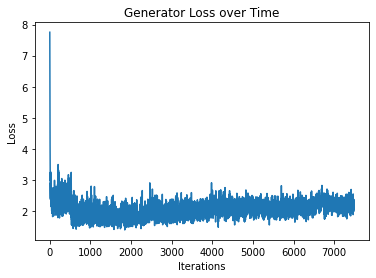

 42%|████▏     | 100/240 [00:20<00:25,  5.45it/s]

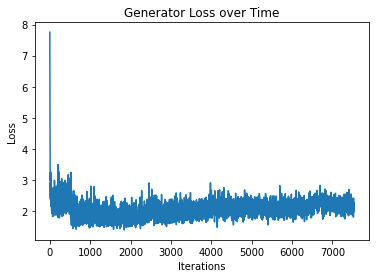

 62%|██████▎   | 150/240 [00:29<00:16,  5.51it/s]

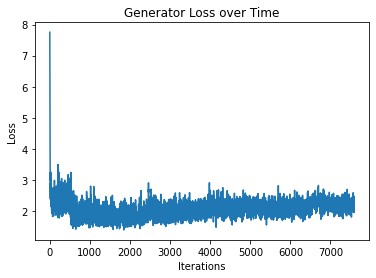

 83%|████████▎ | 200/240 [00:39<00:07,  5.45it/s]

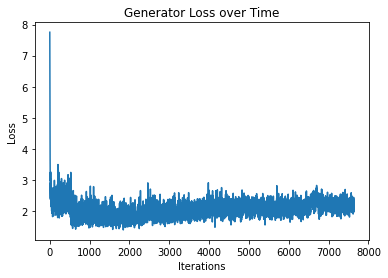

100%|██████████| 240/240 [00:46<00:00,  5.14it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

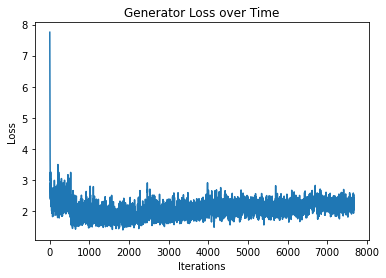

 21%|██        | 50/240 [00:09<00:38,  4.88it/s]

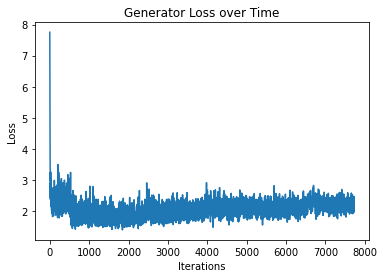

 42%|████▏     | 100/240 [00:19<00:25,  5.54it/s]

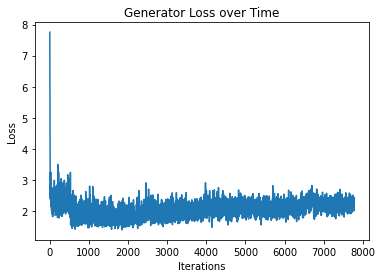

 62%|██████▎   | 150/240 [00:28<00:16,  5.41it/s]

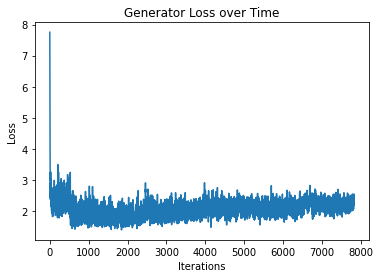

 83%|████████▎ | 200/240 [00:38<00:07,  5.45it/s]

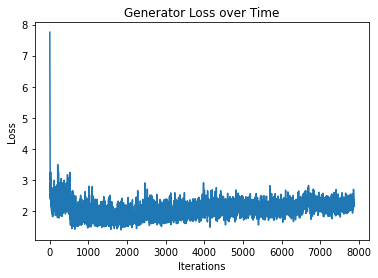

100%|██████████| 240/240 [00:45<00:00,  5.24it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

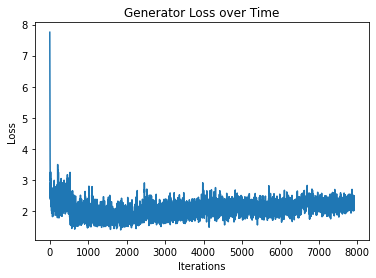

 21%|██        | 50/240 [00:09<00:36,  5.24it/s]

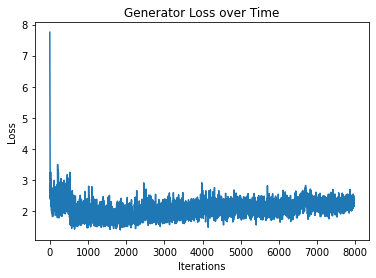

 42%|████▏     | 100/240 [00:19<00:25,  5.57it/s]

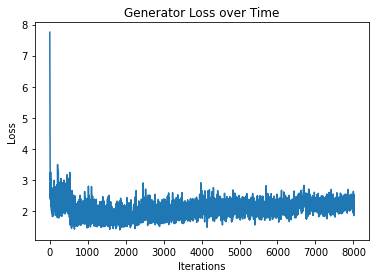

 62%|██████▎   | 150/240 [00:28<00:16,  5.57it/s]

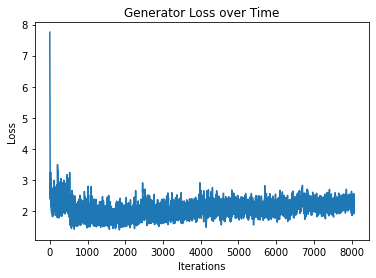

 83%|████████▎ | 200/240 [00:37<00:07,  5.59it/s]

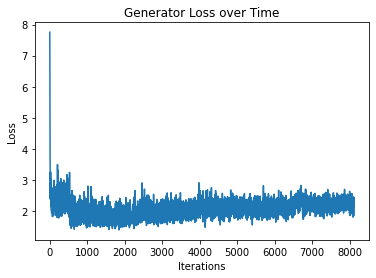

100%|██████████| 240/240 [00:45<00:00,  5.33it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

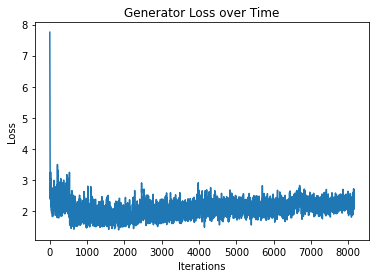

 21%|██        | 50/240 [00:09<00:35,  5.42it/s]

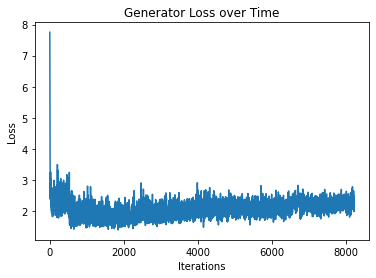

 42%|████▏     | 100/240 [00:19<00:25,  5.58it/s]

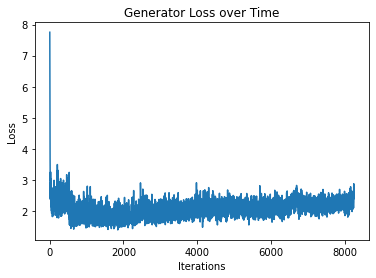

 62%|██████▎   | 150/240 [00:28<00:16,  5.49it/s]

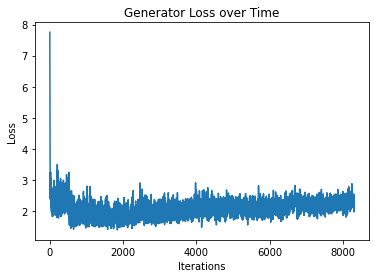

 83%|████████▎ | 200/240 [00:37<00:07,  5.57it/s]

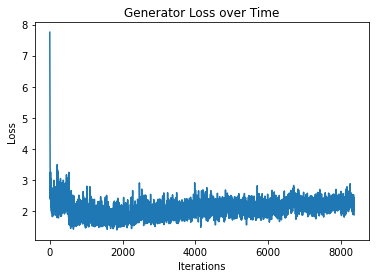

100%|██████████| 240/240 [00:45<00:00,  5.30it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

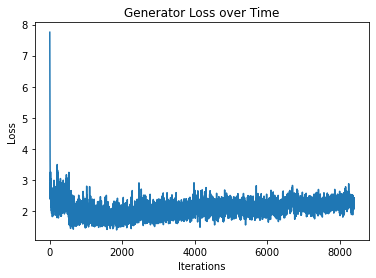

 21%|██        | 50/240 [00:09<00:36,  5.26it/s]

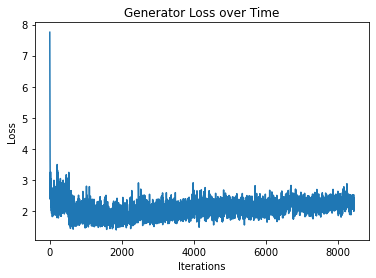

 42%|████▏     | 100/240 [00:19<00:27,  5.08it/s]

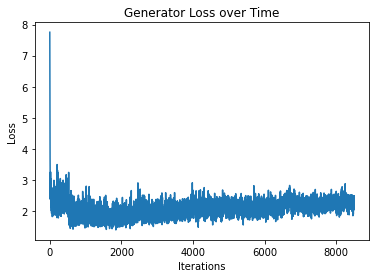

 62%|██████▎   | 150/240 [00:28<00:16,  5.58it/s]

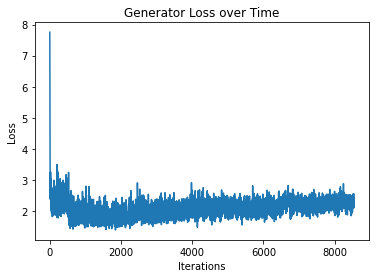

 83%|████████▎ | 200/240 [00:37<00:07,  5.55it/s]

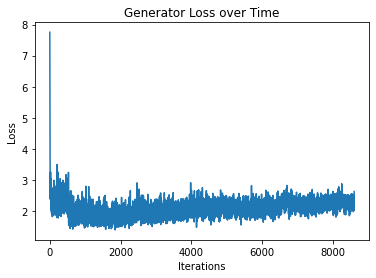

100%|██████████| 240/240 [00:45<00:00,  5.33it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

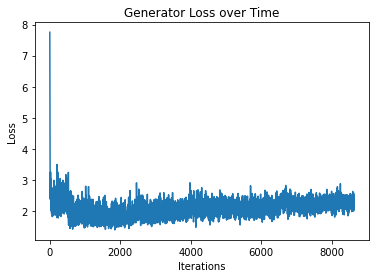

 21%|██        | 50/240 [00:09<00:35,  5.35it/s]

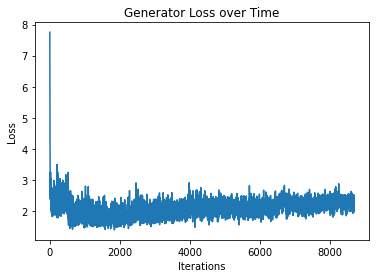

 42%|████▏     | 100/240 [00:18<00:24,  5.61it/s]

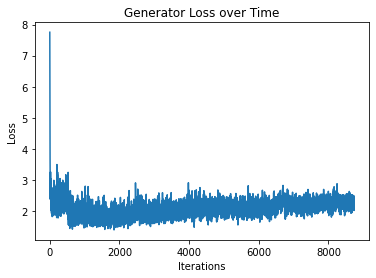

 62%|██████▎   | 150/240 [00:28<00:16,  5.52it/s]

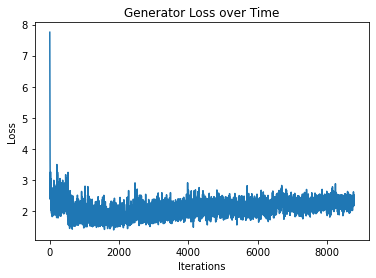

 83%|████████▎ | 200/240 [00:37<00:07,  5.62it/s]

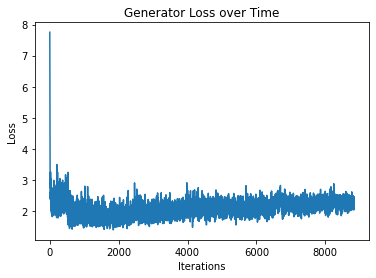

100%|██████████| 240/240 [00:44<00:00,  5.36it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

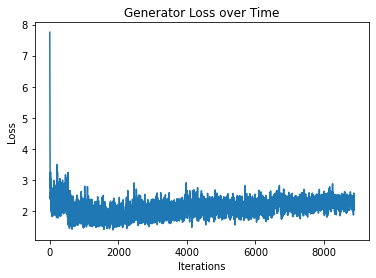

 21%|██        | 50/240 [00:09<00:36,  5.24it/s]

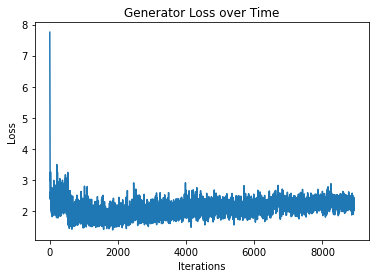

 42%|████▏     | 100/240 [00:19<00:25,  5.57it/s]

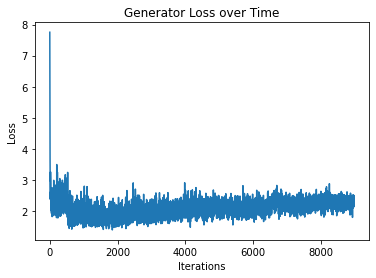

 62%|██████▎   | 150/240 [00:28<00:16,  5.56it/s]

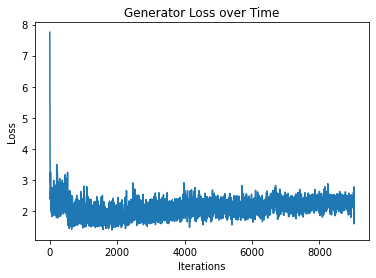

 83%|████████▎ | 200/240 [00:37<00:07,  5.53it/s]

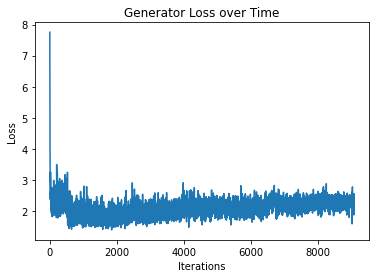

100%|██████████| 240/240 [00:44<00:00,  5.33it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

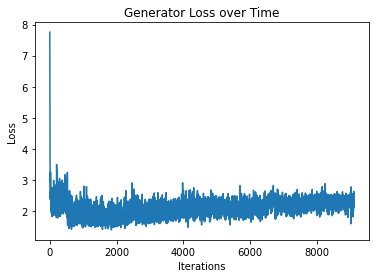

 21%|██        | 50/240 [00:09<00:35,  5.36it/s]

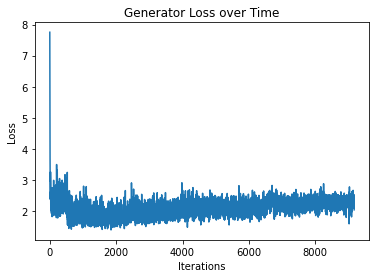

 42%|████▏     | 100/240 [00:19<00:25,  5.52it/s]

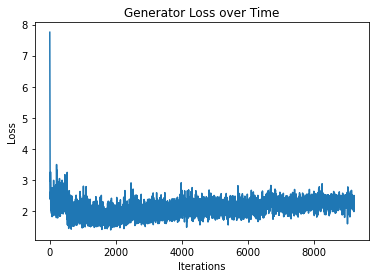

 62%|██████▎   | 150/240 [00:28<00:16,  5.60it/s]

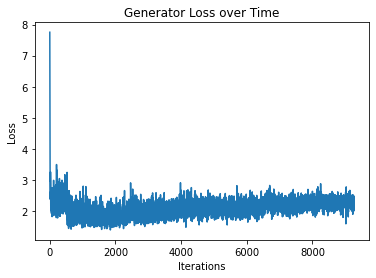

 83%|████████▎ | 200/240 [00:37<00:07,  5.56it/s]

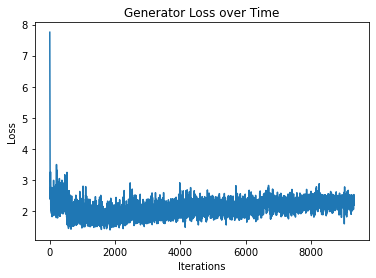

100%|██████████| 240/240 [00:44<00:00,  5.34it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

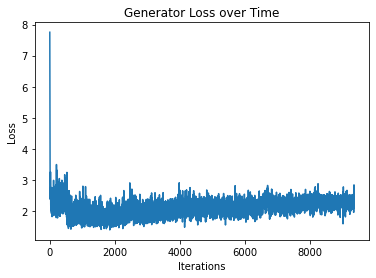

 21%|██        | 50/240 [00:09<00:35,  5.31it/s]

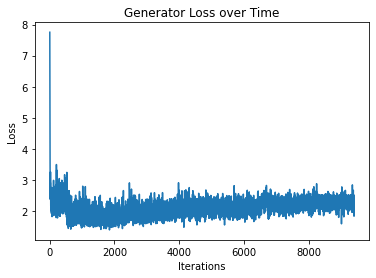

 42%|████▏     | 100/240 [00:19<00:25,  5.42it/s]

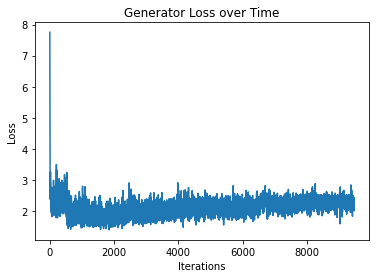

 62%|██████▎   | 150/240 [00:28<00:16,  5.57it/s]

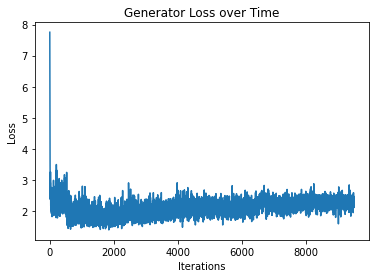

 83%|████████▎ | 200/240 [00:37<00:07,  5.54it/s]

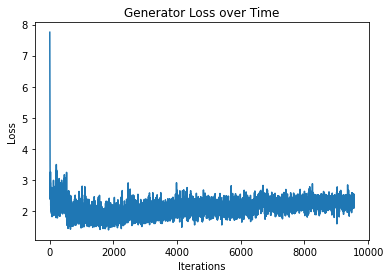

100%|██████████| 240/240 [00:45<00:00,  5.30it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/240 [00:00<?, ?it/s]

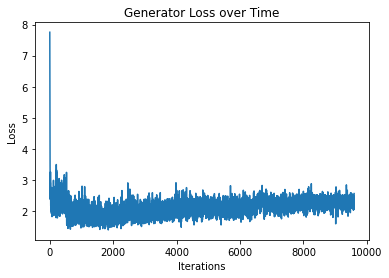

 21%|██        | 50/240 [00:10<00:35,  5.43it/s]

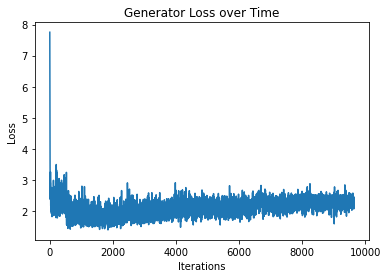

 42%|████▏     | 100/240 [00:20<00:25,  5.51it/s]

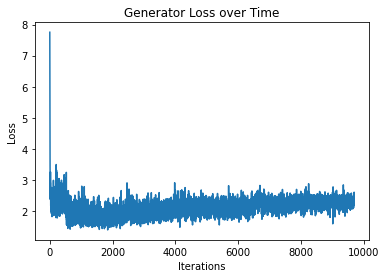

 56%|█████▌    | 134/240 [00:26<00:19,  5.48it/s]

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#variables globales pour afficher l'évolution de la loss
gen_loss_list = []

def train_fn(disc_A, disc_B, gen_A2B, gen_B2A, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler):
    loop = tqdm(loader, leave=True) #progress bar

    for idx, (real_A, real_B) in enumerate(loop):
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Train Discriminators: max log(D(x)) + log(1 - D(G(z)))
        # where D(x) is the probability that the discriminator
        # correctly classifies the real image as real
        # and D(G(z)) is the probability that the discriminator
        # correctly classifies the fake image as fake
        with torch.cuda.amp.autocast():
            fake_B = gen_A2B(real_A)
            disc_real_B = disc_B(real_B)
            disc_fake_B = disc_B(fake_B)
            disc_B_loss = (
                mse(disc_real_B, torch.ones_like(disc_real_B))
                + mse(disc_fake_B, torch.zeros_like(disc_fake_B))
            )

            fake_A = gen_B2A(real_B)
            disc_real_A = disc_A(real_A)
            disc_fake_A = disc_A(fake_A)
            disc_A_loss = (
                mse(disc_real_A, torch.ones_like(disc_real_A))
                + mse(disc_fake_A, torch.zeros_like(disc_fake_A))
            )

            disc_loss = (disc_A_loss + disc_B_loss)/2

        opt_disc.zero_grad() #zero the gradient buffers
        d_scaler.scale(disc_loss).backward() #backward pass
        d_scaler.step(opt_disc) #update the weights
        d_scaler.update() #update the scale for next iteration

        # Train Generators: min log(1 - D(G(z))) <-> max log(D(G(z))
        # Train Generators: min L1(y, G(x)) <-> max L1(y, G(x))
        with torch.cuda.amp.autocast():
            # adversarial loss is binary cross-entropy
            fake_B = gen_A2B(real_A)
            disc_fake_B = disc_B(fake_B)
            gen_A2B_loss = mse(disc_fake_B, torch.ones_like(disc_fake_B)) #mse = mean squared error

            fake_A = gen_B2A(real_B)
            disc_fake_A = disc_A(fake_A)
            gen_B2A_loss = mse(disc_fake_A, torch.ones_like(disc_fake_A)) #mse = mean squared error

            # cycle loss
            recov_A = gen_B2A(fake_B)
            cycle_A_loss = L1(real_A, recov_A)

            recov_B = gen_A2B(fake_A)
            cycle_B_loss = L1(real_B, recov_B)

            # identity loss
            id_A = gen_B2A(real_A)
            id_A_loss = L1(real_A, id_A)

            id_B = gen_A2B(real_B)
            id_B_loss = L1(real_B, id_B) 

            gen_loss = ( #loss of the generator
                gen_B2A_loss
                + gen_A2B_loss
                + cycle_A_loss*LAMBDA_CYCLE
                + cycle_B_loss*LAMBDA_CYCLE
                + id_A_loss
                + id_B_loss
            )
        opt_gen.zero_grad() #zero the gradient buffers
        g_scaler.scale(gen_loss).backward() #backward pass
        g_scaler.step(opt_gen) #update the weights
        g_scaler.update() #update the scale for next iteration
        gen_loss_list.append(gen_loss.item())


        if idx % 50 == 0:
            save_image(fake_A, f"drive/MyDrive/Colab Notebooks/cycleGAN/saved_images/{idx}_fake_A.png")
            save_image(fake_B, f"drive/MyDrive/Colab Notebooks/cycleGAN/saved_images/{idx}_fake_B.png")

            # Plot the generator loss over time
            plt.plot(gen_loss_list)
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.title("Generator Loss over Time")
            plt.show()




def main():

    loss_history_gen = []
    loss_history_id = []
    disc_A = Discriminator(in_channels=1).to(DEVICE)
    disc_B = Discriminator(in_channels=1).to(DEVICE)
    gen_A2B = Generator(img_channels=1, num_residuals=9).to(DEVICE)
    gen_B2A = Generator(img_channels=1, num_residuals=9).to(DEVICE)
    opt_disc = torch.optim.Adam(
        list(disc_A.parameters()) + list(disc_B.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )
    opt_gen = torch.optim.Adam(
        list(gen_A2B.parameters()) + list(gen_B2A.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_A, gen_A2B, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_B, gen_B2A, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_A, disc_A, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_B, disc_B, opt_disc, LEARNING_RATE,
        )
    
    #create the dataset
    

    dataset = customDataset(TRAIN_DIR + "/MRI3/TrainVolumes", TRAIN_DIR + "/MRI4/TrainVolumes")



    
    loader = DataLoader( #create the dataloader
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler() #create the gradient scaler for the generator
    d_scaler = torch.cuda.amp.GradScaler() #create the gradient scaler for the discriminator

    for epoch in range(NUM_EPOCHS): #loop through the epochs
        train_fn(disc_A, disc_B, gen_A2B, gen_B2A, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

        if SAVE_MODEL: #save the model
            save_checkpoint(gen_A2B, opt_gen, filename=CHECKPOINT_GEN_B)
            save_checkpoint(gen_B2A, opt_gen, filename=CHECKPOINT_GEN_A)
            save_checkpoint(disc_A, opt_disc, filename=CHECKPOINT_CRITIC_A)
            save_checkpoint(disc_B, opt_disc, filename=CHECKPOINT_CRITIC_B)

if __name__ == "__main__":
    main()